# Contrastive learning density estimation

Author: Christoph Weniger, June 2020

In [1]:
import numpy as np
import pylab as plt
import swyft
import torch

In [2]:
DEVICE = 'cuda:0'
NDIM = 1  # Dimensionality of parameter z
NROUNDS = 1  # Optimization rounds
N_TRAIN = 3000
N_BATCH = 3

In [3]:
# Generative model, x~p(x|z)
def model(z, sigma = 0.1):
    z = (z-0.5)*4
    x = np.sin(z)
    n = np.random.randn(*x.shape)*sigma    
    return x + n

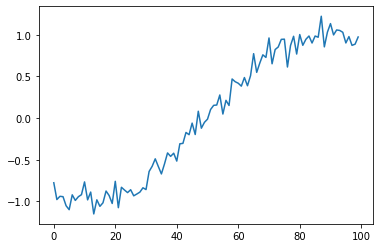

In [4]:
z = np.linspace(0, 1, 100)
z = z.repeat(2).reshape(100,2)
x = [model(z0)[0] for z0 in z]
plt.plot(x)

In [5]:
z0 = np.ones(NDIM)*0.5
x0 = model(z0, sigma = 1e-6)
x0

array([1.33701981e-07])

In [6]:
sw = swyft.SWYFT(model, NDIM, x0, device = DEVICE)

In [7]:
for i in range(NROUNDS):
    sw.round(n_sims = 3000, n_train = [N_TRAIN, N_TRAIN, N_TRAIN], lr = [1e-3, 1e-4, 1e-5], n_batch = N_BATCH)

100%|██████████| 3000/3000 [00:00<00:00, 65606.05it/s]

Round:  0
Generate samples from constrained prior: z~pc(z)
Generate corresponding draws x ~ p(x|z)



  0%|          | 0/3000 [00:00<?, ?it/s]

Network optimization


100%|██████████| 3000/3000 [01:52<00:00, 26.57it/s]


In [9]:
post = []
for i in range(NROUNDS):
    post.append(sw.get_posteriors(nround=i))

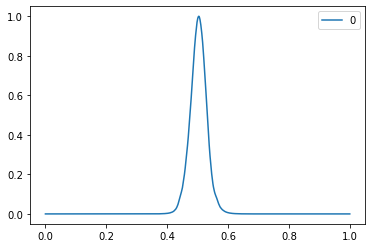

In [12]:
for i in range(NROUNDS):
    plt.plot(post[i][0]['z'], np.exp(post[i][0]['lnL']), label=i)
    #plt.plot(post[i][0]['z'], post[i][0]['lnL'], label=i)
plt.legend()

(0.4, 0.6)

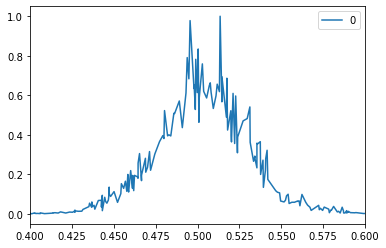

In [19]:
post = []
for i in range(NROUNDS):
    post.append(sw.get_posteriors(nround=i, MC_dropout = True))
for i in range(NROUNDS):
    plt.plot(post[i][0]['z'], np.exp(post[i][0]['lnL']), label=i)
    #plt.plot(post[i][0]['z'], post[i][0]['lnL'], label=i)
plt.legend()
plt.xlim([0.4, 0.6])

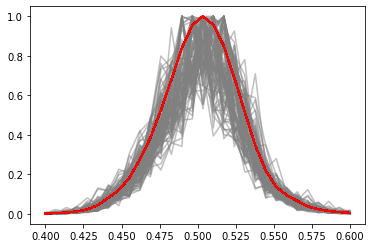

In [41]:
net = sw.net_store[0]
net.train()
z = [np.array([zz]) for zz in np.linspace(0.4, 0.6, 30)]
for i in range(100):
    post = swyft.estimate_lnL(net, x0, z, device = DEVICE)
    plt.plot(post[0]['z'], np.exp(post[0]['lnL']), color='0.5', alpha = 0.5)

net.eval()
for i in range(100):
    post = swyft.estimate_lnL(net, x0, z, device = DEVICE)
    plt.plot(post[0]['z'], np.exp(post[0]['lnL']), color='r', alpha = 0.5)